# Test 3 --- Final Test for 06.11.2025

In [4]:
!pip install gymnasium[atari,accept-rom-license]
!pip install autorom
!pip install stable-baselines3

In [5]:
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.12/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/adventure.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/air_raid.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/alien.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/amidar.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/assault.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/asterix.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/asteroids.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/atlantis.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/atlantis2.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/backgammon.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/bank_heist.bin
Inst

# Install the Gym

In [6]:
import ale_py
import gymnasium as gym

# Configure the model save drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
save_dir = "/content/drive/MyDrive/PUBLIC/Models"
os.makedirs(save_dir, exist_ok=True)

# Now Model

In [9]:
from dataclasses import dataclass
import argparse
import time
from datetime import datetime
import numpy as np
import collections
import typing as tt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard.writer import SummaryWriter

In [29]:
#dqn_model
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        size = self.conv(torch.zeros(1, *input_shape)).size()[-1]
        self.fc = nn.Sequential(
            nn.Linear(size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    def forward(self, x: torch.ByteTensor):
        x = x.float() / 255.0
        return self.fc(self.conv(x))

class DuelingDQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DuelingDQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        size = self.conv(torch.zeros(1, *input_shape)).size()[-1]

        # Value stream V(s)
        self.value = nn.Sequential(
            nn.Linear(size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

        # Advantage stream A(s,a)
        self.advantage = nn.Sequential(
            nn.Linear(size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x: torch.ByteTensor):
        x = x.float() / 255.0
        features = self.conv(x)
        v = self.value(features)                    # [B, 1]
        a = self.advantage(features)                # [B, A]
        q = v + (a - a.mean(dim=1, keepdim=True))   # [B, A]
        return q


In [11]:
#wrappers

from gymnasium import spaces
from stable_baselines3.common import atari_wrappers


class ImageToPyTorch(gym.ObservationWrapper):
    """
    ImageToPyTorch: Reorders image dimensions from (H, W, C) to (C, H, W)
    for compatibility with PyTorch convolutional layers.
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        obs = self.observation_space
        assert isinstance(obs, gym.spaces.Box)
        assert len(obs.shape) == 3
        new_shape = (obs.shape[-1], obs.shape[0], obs.shape[1])
        self.observation_space = gym.spaces.Box(
            low=obs.low.min(), high=obs.high.max(),
            shape=new_shape, dtype=obs.dtype)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class BufferWrapper(gym.ObservationWrapper):
    """
    BufferWrapper: Maintains a rolling window of the last `n_steps` frames
    to give the agent a sense of temporal context.
    """
    def __init__(self, env, n_steps):
        super(BufferWrapper, self).__init__(env)
        obs = env.observation_space
        assert isinstance(obs, spaces.Box)
        new_obs = gym.spaces.Box(
            obs.low.repeat(n_steps, axis=0), obs.high.repeat(n_steps, axis=0),
            dtype=obs.dtype)
        self.observation_space = new_obs
        self.buffer = collections.deque(maxlen=n_steps)

    def reset(self, *, seed: tt.Optional[int] = None, options: tt.Optional[dict[str, tt.Any]] = None):
        for _ in range(self.buffer.maxlen):
            self.buffer.append(np.zeros_like(self.env.observation_space.low))
        obs, extra = self.env.reset()
        return self.observation(obs), extra

    def observation(self, observation: np.ndarray) -> np.ndarray:
        self.buffer.append(observation)
        return np.concatenate(self.buffer)


def make_env(env_name: str, n_steps=4, render_mode=None, **kwargs):
    print(f"Creating environment {env_name}")
    env = gym.make(env_name, render_mode=render_mode, **kwargs)
    env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=n_steps)
    return env

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [32]:
# Base Configuration
DEFAULT_ENV_NAME = "ALE/Pong-v5"
MEAN_REWARD_BOUND = 19

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
LEARNING_RATE = 2.5e-4
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000

SAVE_EPSILON = 0.5
EPSILON_DECAY_LAST_FRAME = 150000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01

# Tuple of tensors returned from a sampled minibatch in replay buffer
State = np.ndarray
Action = int
BatchTensors = tt.Tuple[
    torch.ByteTensor,           # current state
    torch.LongTensor,           # actions
    torch.Tensor,               # rewards
    torch.BoolTensor,           # done || trunc
    torch.ByteTensor            # next state
]

In [13]:
# ⚙️ Fast Training Config for Quick Test Run
# MEAN_REWARD_BOUND = 5
# REPLAY_START_SIZE = 1000
# EPSILON_DECAY_LAST_FRAME = 10_000
# SYNC_TARGET_FRAMES = 500

# REPLAY_SIZE = 5000  # optional
# BATCH_SIZE = 16     # optional

In [14]:
import os
from pathlib import Path

# Define directories
save_dir_drive = "/content/drive/MyDrive/PUBLIC/Models"
save_dir_local = "saved_models"

# Create both directories if they don't exist
os.makedirs(save_dir_drive, exist_ok=True)
os.makedirs(save_dir_local, exist_ok=True)

# Safe model filename
env_name = DEFAULT_ENV_NAME
safe_env_name = env_name.replace("/", "_")

In [15]:
@dataclass
class Experience:
    state: State
    action: Action
    reward: float
    done_trunc: bool
    new_state: State


class ExperienceBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience: Experience):
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> tt.List[Experience]:
        indices = np.random.choice(len(self), batch_size, replace=False)
        return [self.buffer[idx] for idx in indices]

In [16]:
class Agent:
    def __init__(self, env: gym.Env, exp_buffer: ExperienceBuffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self.state: tt.Optional[np.ndarray] = None
        self._reset()

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net: DQN, device: torch.device,
                  epsilon: float = 0.0) -> tt.Optional[float]:
        done_reward = None

        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state_v = torch.as_tensor(self.state).to(device)
            state_v.unsqueeze_(0)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, is_tr, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(
            state=self.state, action=action, reward=float(reward),
            done_trunc=is_done or is_tr, new_state=new_state
        )
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done or is_tr:
            done_reward = self.total_reward
            self._reset()
        return done_reward

In [17]:
def batch_to_tensors(batch: tt.List[Experience], device: torch.device) -> BatchTensors:
    states, actions, rewards, dones, new_state = [], [], [], [], []
    for e in batch:
        states.append(e.state)
        actions.append(e.action)
        rewards.append(e.reward)
        dones.append(e.done_trunc)
        new_state.append(e.new_state)
    states_t = torch.as_tensor(np.asarray(states))
    actions_t = torch.LongTensor(actions)
    rewards_t = torch.FloatTensor(rewards)
    dones_t = torch.BoolTensor(dones)
    new_states_t = torch.as_tensor(np.asarray(new_state))
    return states_t.to(device), actions_t.to(device), rewards_t.to(device), \
           dones_t.to(device),  new_states_t.to(device)

In [18]:
def calc_loss(batch: tt.List[Experience], net: DQN, tgt_net: DQN,
              device: torch.device) -> torch.Tensor:
    states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch, device)


    q_sa = net(states_t).gather(1, actions_t.unsqueeze(-1)).squeeze(-1)


    with torch.no_grad():
        next_actions = net(new_states_t).argmax(dim=1)  # a* = argmax_a Q_online(s',a)
        next_q = tgt_net(new_states_t).gather(1, next_actions.unsqueeze(-1)).squeeze(-1)
        next_q[dones_t] = 0.0
        target = rewards_t + GAMMA * next_q

    return nn.MSELoss()(q_sa, target)


In [33]:
model_comment = f"test_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_sync{SYNC_TARGET_FRAMES}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = make_env(env_name)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment=f"-{env_name}-{model_comment}")
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
# Training loop – finite number of episodes for baseline curve
MAX_EPISODES = 300

total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None
start_time = time.time()

while len(total_rewards) < MAX_EPISODES:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        elapsed = time.time() - start_time  # in seconds
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])

        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)

        print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
              f"eps {epsilon:.2f}, speed {speed:.2f} f/s, episodes {len(total_rewards)}/{MAX_EPISODES}")

        # Save best model so far
        if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
            timestamp = datetime.now().strftime("%Y%m%d-%H%M")
            model_filename = f"{safe_env_name}-baseline_best_{int(m_reward)}-{timestamp}.dat"

            model_path_drive = os.path.join(save_dir_drive, model_filename)
            model_path_local = os.path.join(save_dir_local, model_filename)

            torch.save(net.state_dict(), model_path_drive)
            torch.save(net.state_dict(), model_path_local)

            print(f"💾 Model saved to:\n - Google Drive: {model_path_drive}\n - Local:        {model_path_local}")
            if best_m_reward is not None:
                print(f"Best reward updated {best_m_reward:.3f} -> {m_reward:.3f}")
            best_m_reward = m_reward

    if len(buffer) < REPLAY_START_SIZE:
        continue

    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device)
    loss_t.backward()
    optimizer.step()

env.close()
writer.close()

print("Training finished.")
print("Total episodes:", len(total_rewards))
print("First 10 rewards:", total_rewards[:10])
print("Last 10 rewards:", total_rewards[-10:])



Creating environment ALE/Pong-v5
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
237: done 1 games, reward -19.000, eps 1.00, speed 425.32 f/s, episodes 1/300
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-baseline_best_-19-20251124-0147.dat
 - Local:        saved_models/ALE_Pong-v5-baseline_best_-19-20251124-0147.dat
473: done 2 games, reward -19.500, eps 1.00, speed 384.85 f/s, episodes 2/300
700: done 3 games, reward -20.000, eps 1.00, speed 397.30 f/s, episodes 3/300
955: done 4 games, reward -19.750, eps 0.99, speed 287.03 f/s, episodes 4

In [24]:
print("Episodes collected:", len(total_rewards))
print("Sample of rewards:", total_rewards[:10])


Episodes collected: 2
Sample of rewards: [-20.0, -21.0]


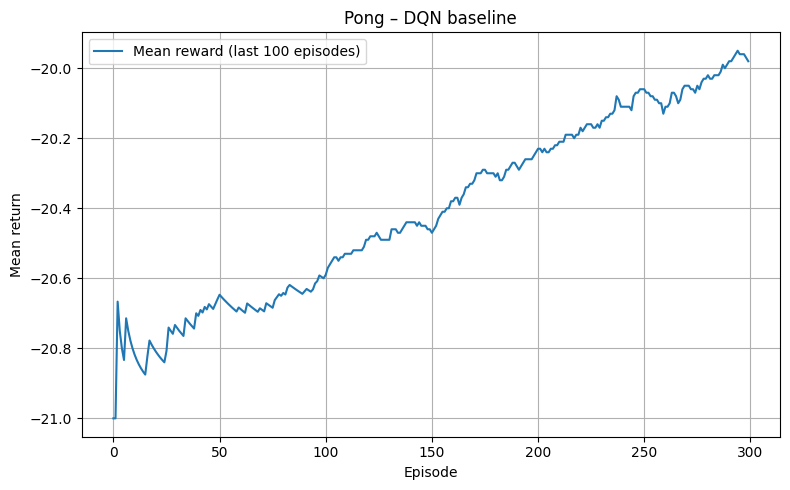

In [26]:
import numpy as np
import matplotlib.pyplot as plt

episode_indices = np.arange(len(total_rewards))
moving_avg = []

for i in range(len(total_rewards)):
    start = max(0, i - 99)  # last 100 episodes
    moving_avg.append(np.mean(total_rewards[start:i+1]))

plt.figure(figsize=(8, 5))
plt.plot(episode_indices, moving_avg, label="Mean reward (last 100 episodes)")
plt.xlabel("Episode")
plt.ylabel("Mean return")
plt.title("Pong – DQN baseline")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig("curve_dqn_baseline.png", dpi=150)

plt.show()


Total episodes: 300


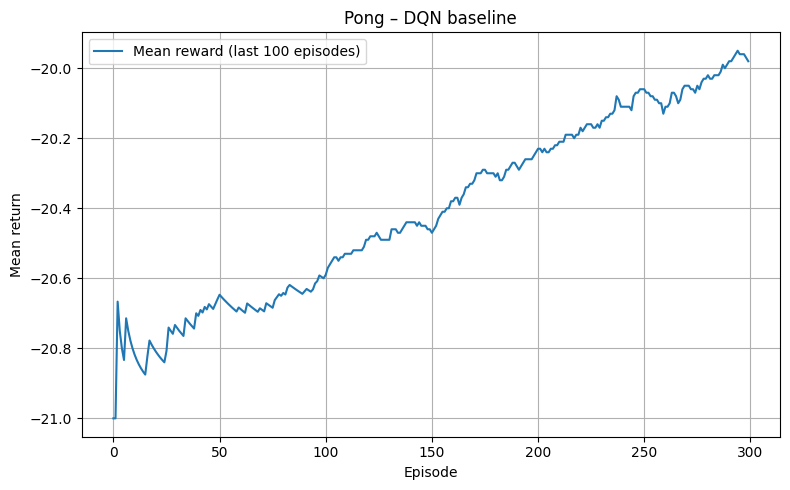

In [27]:
import numpy as np
import matplotlib.pyplot as plt

print("Total episodes:", len(total_rewards))

episode_indices = np.arange(len(total_rewards))
moving_avg = []

for i in range(len(total_rewards)):
    start = max(0, i - 99)  # last 100 episodes
    moving_avg.append(np.mean(total_rewards[start:i+1]))

plt.figure(figsize=(8, 5))
plt.plot(episode_indices, moving_avg, label="Mean reward (last 100 episodes)")
plt.xlabel("Episode")
plt.ylabel("Mean return")
plt.title("Pong – DQN baseline")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig("curve_dqn_baseline.png", dpi=150)
plt.show()


Total episodes: 300


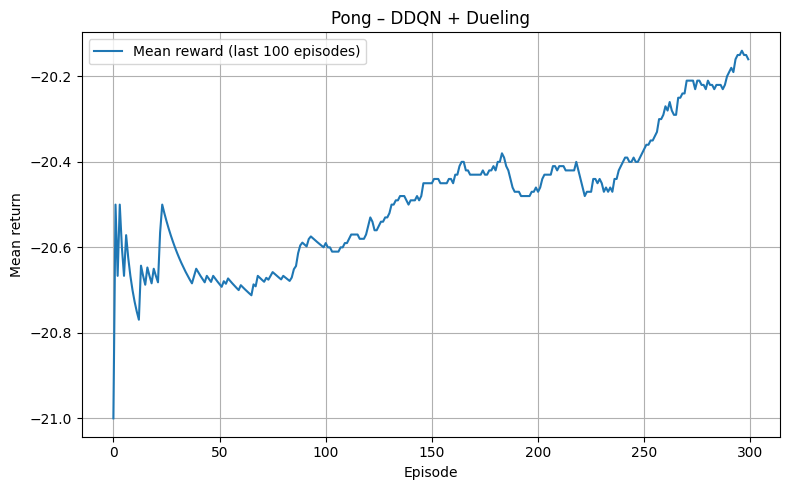

In [31]:
import numpy as np
import matplotlib.pyplot as plt

print("Total episodes:", len(total_rewards))

episode_indices = np.arange(len(total_rewards))
moving_avg = []

for i in range(len(total_rewards)):
    start = max(0, i - 99)  # last 100 episodes
    moving_avg.append(np.mean(total_rewards[start:i+1]))

plt.figure(figsize=(8, 5))
plt.plot(episode_indices, moving_avg, label="Mean reward (last 100 episodes)")
plt.xlabel("Episode")
plt.ylabel("Mean return")
plt.title("Pong – DDQN + Dueling")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig("curve_pong_ddqn_dueling.png", dpi=150)
plt.show()


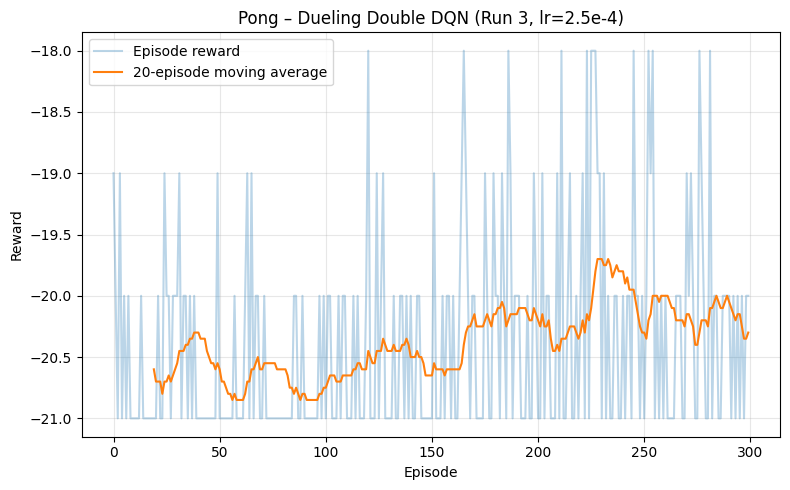

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Convert rewards to numpy array
rewards = np.array(total_rewards, dtype=float)

# Moving average window
window = 20
if len(rewards) >= window:
    moving_avg = np.convolve(rewards, np.ones(window) / window, mode='valid')
else:
    moving_avg = rewards

plt.figure(figsize=(8, 5))
plt.plot(rewards, alpha=0.3, label='Episode reward')
if len(rewards) >= window:
    plt.plot(np.arange(window - 1, len(rewards)), moving_avg,
             label=f'{window}-episode moving average')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Pong – Dueling Double DQN (Run 3, lr=2.5e-4)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()


plt.savefig('curve_pong_final.png', dpi=150)
plt.show()
